In [889]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import sys
import tensorflow as tf

proj_home_path="C:/vrsk.psk.family/Selva/BitsPilani/azure/semester4/semester4/SuperPoint"
sys.path.append(proj_home_path)

from superpoint.settings import EXPER_PATH
from superpoint.models.utils import box_nms 
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1274]:
def non_max_suppression_fast(boxes, overlapThresh):
 	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [1275]:
def _name(path):
    return Path(path.decode('utf-8')).stem

def _read_image(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_png(image, channels=1)
    return tf.cast(image, tf.float32)

# Python function
def _read_points(filename):
    points = np.load(filename.decode('utf-8'))
    points = np.round(points)
    return np.load(filename.decode('utf-8')).astype(np.int32) #.reshape(-1,2)

def _read_magic_points(filename):
    mp = np.load(filename.decode('utf-8'))
    prob = mp['prob']
    pred = np.round(mp['pred'])
    prob_nms = mp['prob_nms']
    
    idx = np.where(prob_nms >= 0.0001)
    prob_nms = prob_nms[idx]
    idx = np.array(idx).T    
    pred = idx.astype(np.int32)

#     print('magic_point: prob.shape, pred.shape, prob_nms.shape ', prob.shape, pred.shape, prob_nms.shape)
#     print('idx: ', idx)
    
    f_output = [prob, pred, prob_nms]
    return f_output

def magicpoint(img_name_with_path):
    point = tf.py_func(_read_magic_points, [img_name_with_path], [tf.float32,tf.int32,tf.float32])
#     print(point)
    f_output = {'prob': point[0], 'points_nms': point[1], 
                "prob_nms" : point[2]} 
    return f_output

def harris_gen(im):
    filename1 = im.decode('utf-8')
    img = cv2.imread(filename1)
    img = np.uint8(img * 255)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)

    keep_top_k = 300
    size = 4 
    size = size/2.
    overlap_threshold = 0.01

    ######### Location & Prob from Harris ##################
    pts = np.where(dst > 0.01 * dst.max())
    scores = dst[pts]
    
    ########## Frame box & Suppress using NMS ###############
    pts = np.array(pts).T
    box = np.concatenate([pts-size, pts+size], axis=1)
    indices = non_max_suppression_fast(box, overlap_threshold)
    indices = indices[:,:2]+size
    indices = np.round(indices).astype(np.int32)
    indices_t = np.array(indices).T
    
#     print('indices, indices_t: ',indices.shape, indices_t.shape)
    
    ########## Location & Prob after NMS ####################
    nms_pts = tuple(indices_t[0]),tuple(indices_t[1])
    nms_scores = dst[nms_pts]
#     print('indices, nms_scores: ',indices.shape, nms_scores.shape)
    f_output = [scores.astype(np.float32), indices.astype(np.int32), nms_scores.astype(np.float32)] #.astype(np.float32)
    return f_output #indices.astype(np.float32)

def harris_detector(im):
    threshold = 0.001
    nms = 4.
    top_k = 300
    point = tf.py_func(harris_gen, [im], [tf.float32,tf.int32,tf.float32])
#     print(point)
    f_output = {'prob': point[0], 'points_nms': point[1], 
                "prob_nms" : point[2]} 
    return f_output


def keypoint_map(image, keypoints):
    image_shape = image.shape[:2]
    keypoints_rounded = np.round(keypoints).astype(np.int32)
    keypoint_map = np.zeros(image_shape)
    kp = np.minimum(keypoints_rounded,(image_shape[0]-1,image_shape[1]-1))
    
    idx = np.array(kp).T
    row,col = tuple(idx[0]),tuple(idx[1])
    keypoint_map[row,col] = 1
    return keypoint_map.astype(np.int32)




In [1276]:
def draw_keypoints(img, corners, color):
    keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in corners]
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)


def display(d):
    return draw_keypoints(d['image'], d['keypoints'], (0, 255, 0))


def display_harris(d):
    dst = d['harris_points']['points_nms'].reshape([-1,2])
    img = d['image']
    return draw_keypoints(img, dst, (0, 255, 0))


def display_magic(d):
    img = d['image']
    idx = d['magic_points']['points_nms']
#     idx = np.where(dst == 1)
    idx = np.array(idx).T
    idx = idx.reshape([-1,2])
    return draw_keypoints(img, idx, (0, 255, 0))


In [1277]:
def getDataIter(shape_dir_list, data_dir, img_dir,p_dir, magic_point_data_dir, magic_point_dir, num_images_per_shape ):
    '''
        shape_dir_list : directory name that holds specific type of shapes
        num_images_per_shape: number of images randomly picked from the shapes directory
        data_dir: base directory for both images and corner points
        idir: full directory path for specifc shape generation
        pdir: full directory path for specifc corner points generation
    '''
    #================= LIST RANDOM FILES =============================
    ifiles =  []
    pfiles = []
    mfiles = []
 
    # Randomly pick num_images_per_shape count of images
    for sdir in shape_dir_list:
        idir = data_dir+sdir+img_dir
        pdir = data_dir+sdir+p_dir
        mdir = magic_point_data_dir+sdir+magic_point_dir
        ifiles_list = [f for f in os.listdir(idir)]
        random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
        random_pfiles = [ f.replace(".png",".npy") for f in random_ifiles]
        random_mfiles = [ f.replace(".png",".npz") for f in random_ifiles]
        
        random_ifiles = [os.path.join(idir, f) for f in random_ifiles]
        random_pfiles = [os.path.join(pdir, f) for f in random_pfiles]
        random_mfiles = [os.path.join(mdir, f) for f in random_mfiles]
        # Accumulate images in list for later operations.
        if ifiles == None:
            ifiles = random_ifiles
            pfiles = random_pfiles
            mfiles = random_mfiles
        else:    
            ifiles = ifiles + random_ifiles
            pfiles = pfiles + random_pfiles
            mfiles = mfiles + random_mfiles

    #================ READ LISTED FILES ===========================
   
    data = tf.data.Dataset.from_tensor_slices(
            (ifiles, pfiles, mfiles))
    
    data = data.map(
            lambda image, points, magic_points:
                    (_read_image(image), 
                     tf.reshape(tf.py_func(_read_points, [points], tf.int32), [-1,2]), 
                     tf.py_func(_name, [image], tf.string), 
                     tf.py_func(_name, [points], tf.string),
                     harris_detector(image),
                     magicpoint(magic_points),
                    image,
                    magic_points
                    ))
    print('----------------completed data#1')
    data = data.map(lambda image, kp, image_name, point_name, harris_point, magic_point, image_path, magic_point_path: 
                                                                { 
                                                                'image': image, 
                                                                'keypoints': kp, 
                                                                'image_name': image_name, 
                                                                'point_name': point_name, 
                                                                'magic_points_path': magic_point_path,
                                                                'magic_points' : magic_point,
                                                                'image_path': image_path,
                                                                'harris_points' : harris_point,
                                                                'keypoints_map' : tf.py_func(keypoint_map,[image,kp],tf.int32)   
                                                               }
                   )
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

##################################################################################################
## Utilize above functions to generate image iterator in tensorflow.
# from Pm_Util import getDataIter
import tensorflow as tf

##Shapes generated by synthetic_shapes_generator
shape_dir_list = ['draw_checkerboard','draw_cube','draw_ellipses',
                  'draw_lines','draw_multiple_polygons','draw_star',
                  'draw_stripes']
num_images_per_shape = 6
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\tmp\\"
##Generator generates data for train, test and validation. Here picking data from test to view
img_dir = '\\images\\test\\'
p_dir = '\\points\\test\\'

##Data predicted by Maginpoint model
magic_point_data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\magic-point_synth-export_all\\"
##Generator generates data for train, test and validation. Here picking data from test to view
magic_point_dir = '\\points\\test\\'

data = getDataIter(shape_dir_list, data_dir, img_dir, p_dir, magic_point_data_dir, magic_point_dir, num_images_per_shape)

# PRECISION RECALL CURVE

In [1281]:
def compute_precision_recall(synth_kp_map, synth_kp, model_kp, model_prob, dist_threshold):

    gt = np.where(synth_kp_map)
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    
    prob = model_prob
    pred = model_kp 
#     print('model_kp.shape, model_prob.shape,n_gt ', pred.shape, prob.shape, n_gt)
    
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]
    
    diff = np.expand_dims(gt, axis=1) - np.expand_dims(pred, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, dist_threshold)
#     print('matches.shape, prob.shape ', matches.shape, prob.shape)

    tp = []
    matched = np.zeros(len(gt))
#     print('matched.shape ', matched.shape)
    for m, m_idx in zip(matches, range(len(gt))):
        
        if np.any(m):
            gt_idx = np.argmax(m)
#             print('gt_idx, m.shape: ',gt_idx, m.shape)
            if matched[m_idx] == 0 :
                matched[m_idx] = prob[gt_idx]
                tp.append(True)
            else:
                tp.append(False)
        else:
            tp.append(False)
            
    
    tp = np.array(tp, bool)
    fp = np.logical_not(tp)

    return tp, fp, matched, n_gt
    

In [1282]:

def experiment_level_pr( exp_name, dist_threshold ):
#     dist_threshold = dist_threshold
    tp, fp, prob, n_gt = [], [], [], 0
    data = getDataIter(shape_dir_list, data_dir, img_dir, p_dir, magic_point_data_dir, magic_point_dir, num_images_per_shape)
    while True:
        try:
            data_rec = next(data)
            synth_kp = data_rec['keypoints']
            synth_kp_map = data_rec['keypoints_map']
#             print(synth_kp.shape, synth_prob.shape)
            exp_kp = data_rec[exp_name]['points_nms']
            exp_prob = data_rec[exp_name]['prob_nms']
#             print('exp_kp.shape, exp_prob.shape: ',exp_kp.shape, exp_prob.shape)

            t, f, p, n = compute_precision_recall(synth_kp_map, synth_kp, exp_kp, exp_prob, dist_threshold)
#             print(t.shape, f.shape, p.shape, n)
            tp.append(t)
            fp.append(f)
            prob.append(p)
#             print(tp, fp, prob)
            n_gt += n

        except tf.errors.OutOfRangeError:
            break

    tp = np.concatenate(tp)
    fp = np.concatenate(fp)
    prob = np.concatenate(prob)
#     print('tp.shape, fp.shape, prob.shape: ', tp.shape, fp.shape, prob.shape)
    # Sort in descending order of confidence
    sort_idx = np.argsort(prob)[::-1]
    tp = tp[sort_idx]
    fp = fp[sort_idx]
    prob = prob[sort_idx]

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recall = np.where(n_gt == 0, n_gt, tp_cum/n_gt)
    precision = np.where(tp_cum+fp_cum == 0, 0, tp_cum/(tp_cum+fp_cum))

    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[0], precision, [0]])
    precision = np.maximum.accumulate(precision[::-1])[::-1]

    return precision, recall, prob

In [1283]:
def compute_mAP(precision, recall):
    """
    Compute average precision.
    """
    return np.sum(precision[1:] * (recall[1:] - recall[:-1]))

            lambda image, points, magic_points:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda image, points, magic_points:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
----------------completed data#1
> magic_points
mAP: 0.9761336515513126
            lambda image, points, magic_points:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda image, points, magic_points:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
----------------completed data#1
> harris_points
mAP: 0.7587822014051522


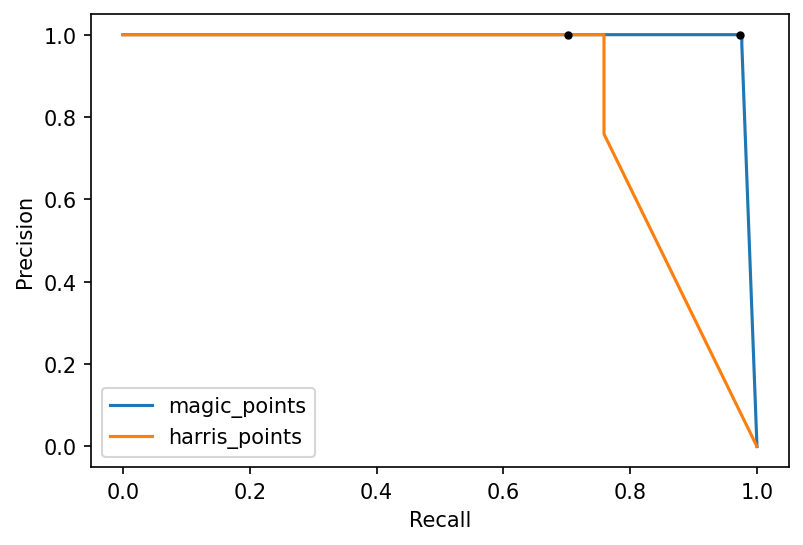

In [1284]:
experiments = [
    'magic_points','harris_points'
]
confidence_thresholds = [0.001,90000]
plt.figure(dpi=150)
for e, t in zip(experiments, confidence_thresholds):
    p, r, prob = experiment_level_pr(e, dist_threshold=4)
    plt.plot(r, p, label=e);
    
    mAP = compute_mAP(p, r)
    print('> {}'.format(e))
    print('mAP: {}'.format(mAP))
    
    op_idx = np.max(np.where(prob > t))
    plt.plot(r[op_idx], p[op_idx], marker='o', color='k', markersize=3)
    
plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');

# DISPLAY INTEREST POINTS DETECTED BY MAGIC POINT

range(1, 60, 3) 20
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)
(120, 160) (120, 160) (120, 160)


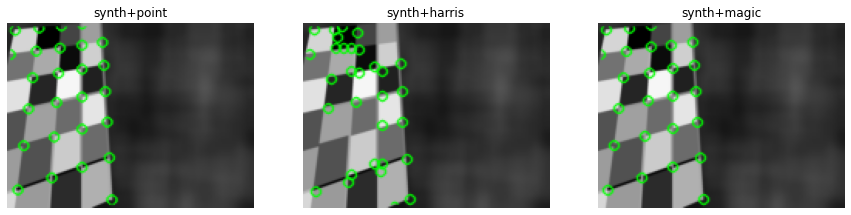

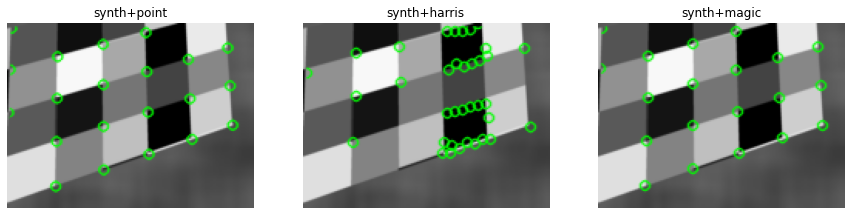

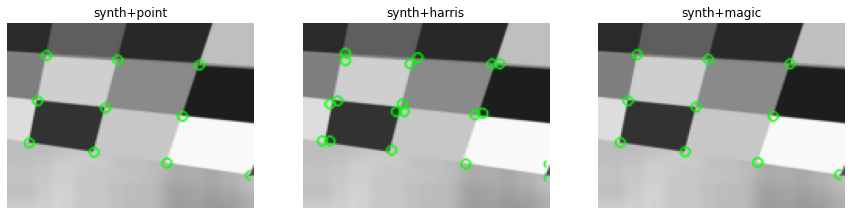

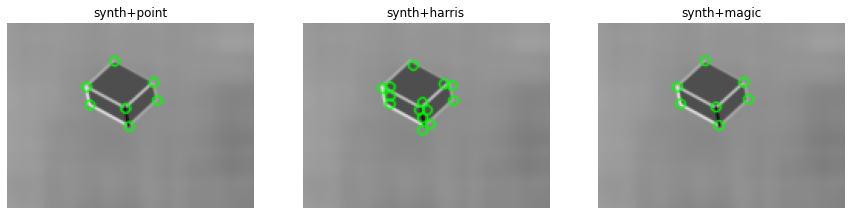

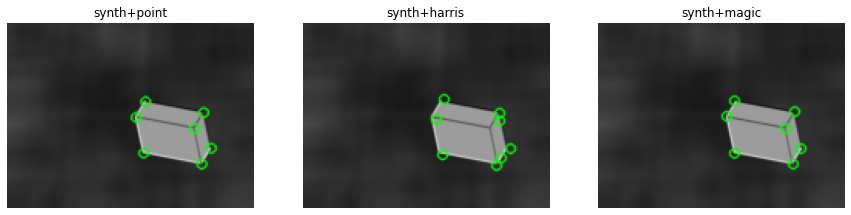

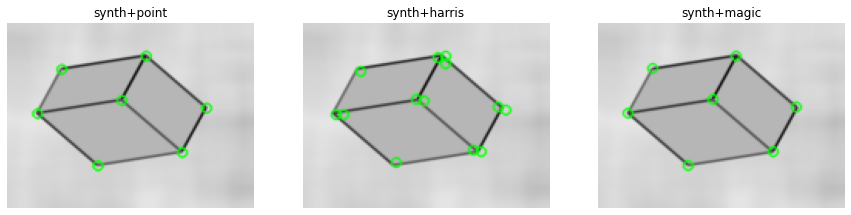

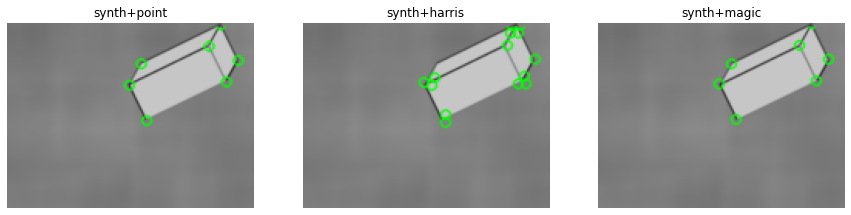

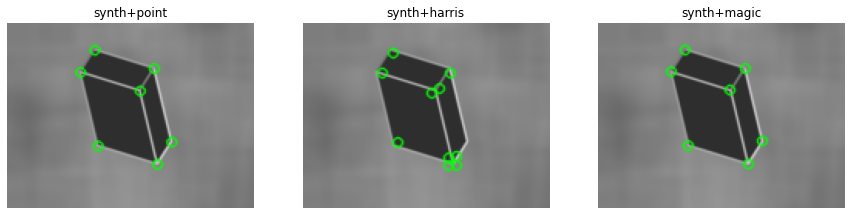

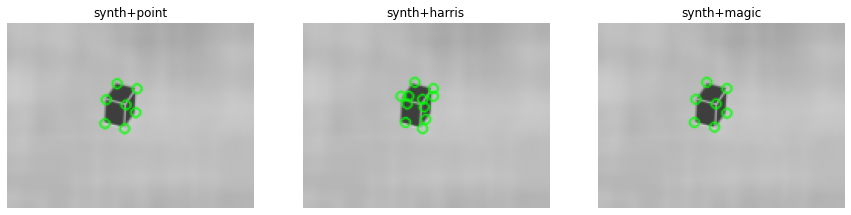

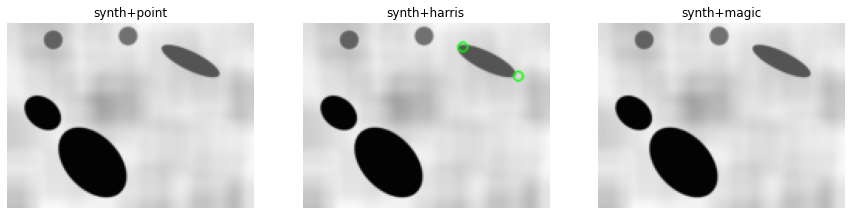

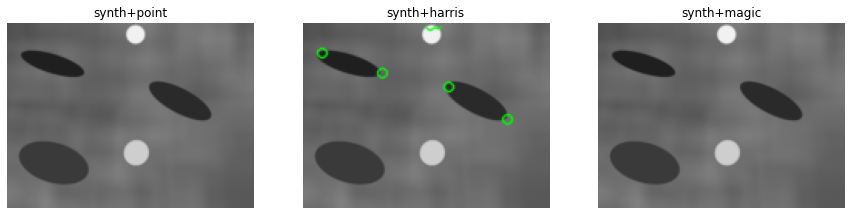

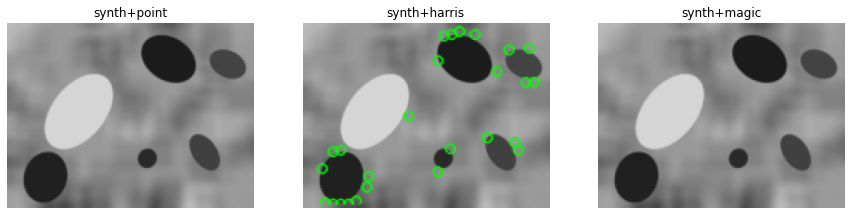

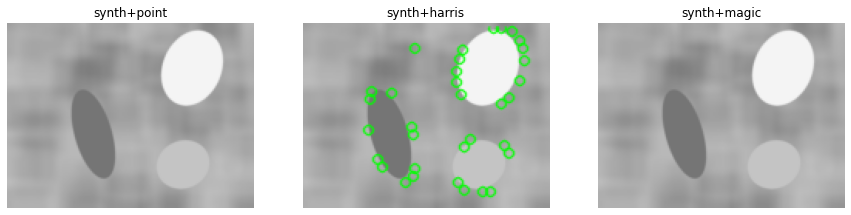

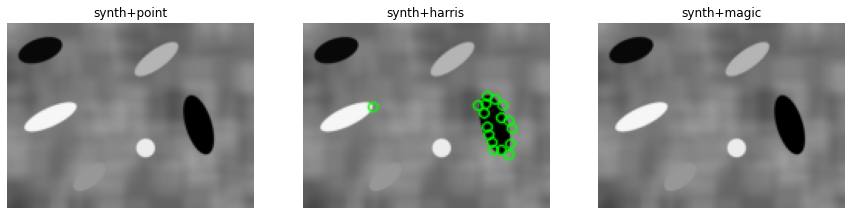

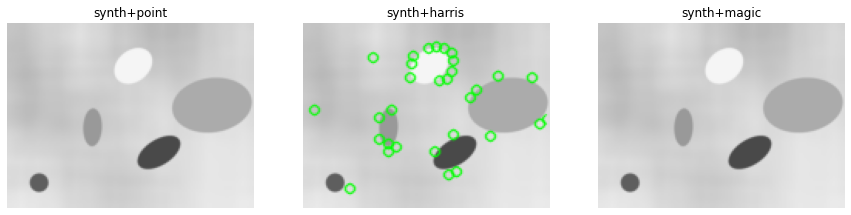

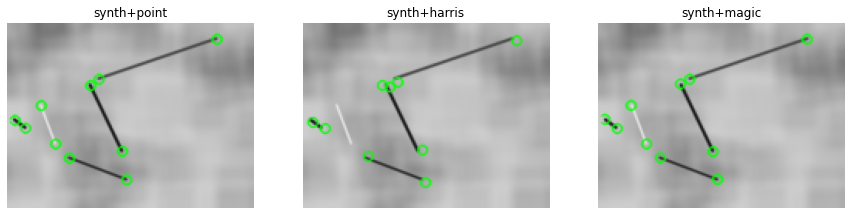

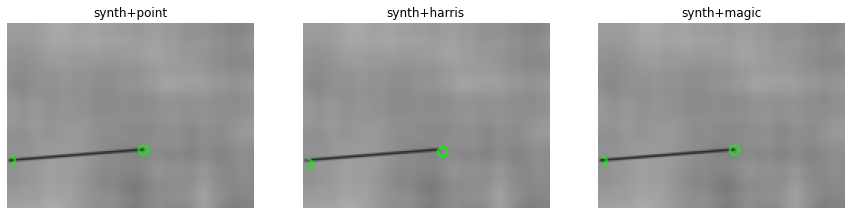

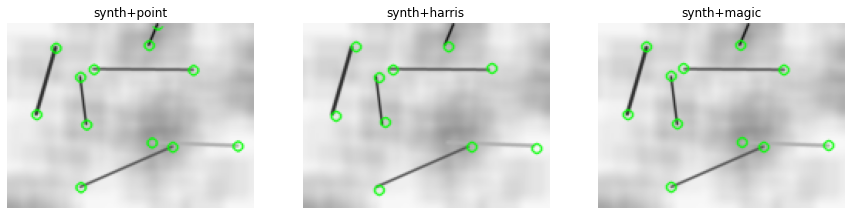

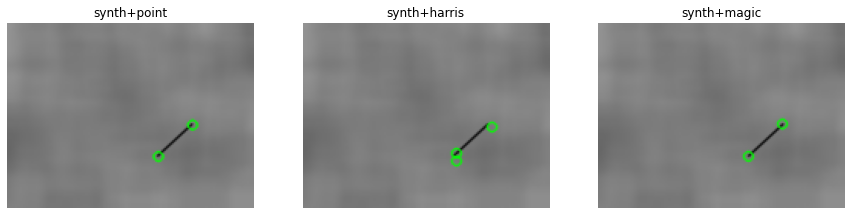

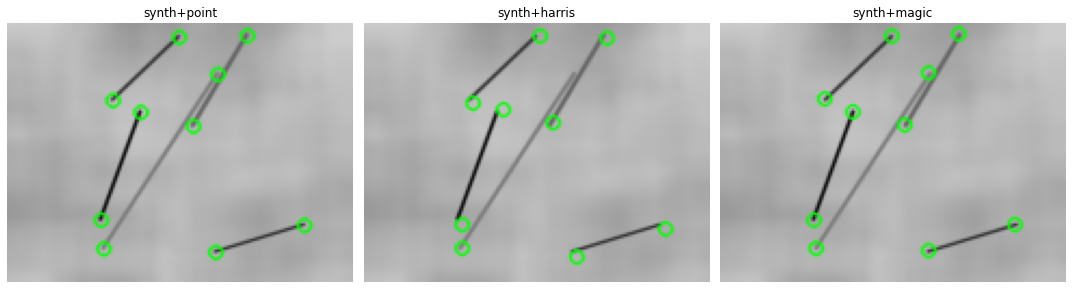

In [1030]:
## Plot synthetic images generated.
Tot = 60
Cols = 3

# Compute Rows required
Rows = Tot // Cols  # it should be 14
Rows += Tot % Cols # ZERO added

# Create a Position index
Position = range(1,Tot,Cols)
print(Position, Rows)

# _, axs = plt.subplots(1, Tot, figsize=(Cols*Tot, Cols), dpi=100)
# fig, axs = plt.subplots(Rows, Cols, figsize=(10, 3))
for k in Position:
    try:
        data_rec = next(data)
#         print(data_rec['image_name'])
        source_img = display(data_rec.copy())
        harris_img = display_harris(data_rec.copy())
        magic_img = display_magic(data_rec.copy())
        keypoint_map = data_rec['keypoints_map']
        
        fig , a =  plt.subplots(1,Cols, figsize = (15,5))
        for ax, incr in zip(a,range(0,Cols)):
            if incr == 0:
                ax.imshow(source_img)
                ax.get_yaxis().set_ticks([])
                ax.get_xaxis().set_ticks([])
                ax.set_title(str('synth+point'))
            if incr == 1:
                ax.imshow(harris_img)
                ax.get_yaxis().set_ticks([])
                ax.get_xaxis().set_ticks([])
                ax.set_title(str('synth+harris'))
            if incr == 2:
                ax.imshow(magic_img)
                ax.get_yaxis().set_ticks([])
                ax.get_xaxis().set_ticks([])
                ax.set_title(str('synth+magic'))

                
                
            for spine in ax.spines.values():  # remove frame
                spine.set_visible(False)

    except tf.errors.OutOfRangeError:
        break

plt.tight_layout()